# Cleaning and EDA as preparation
### 0.Preparation
- load github repo for ... 
- create new kernel at project root

### 1. Ideation and Planning

- look at columns entries (what is interesting information, what needs clarity in terminoloh, what datatypes are used, where could be problems with datatypes (NaN...) which columns are highly populated and what not)
- is it balanced or imbalanced
- first view lets me think coin type and dating (possible research question: )
- 

In [41]:
#data loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

coins_raw = pd.read_csv("../data/A14_Conington_coin_data02.csv")
#coins_raw.info()
coins_raw
#coins_raw.head()

,SITECODE,PERIOD,LU_INT,LU_PROCESS,GP,SGP,CONTEXT,BASIC_INT,PARENT_CONTEXT,BASIC_PROCESS,...,DENOMINATION,DIAMETER,MINT,COIN_MONEYER,COIN_CONDITION,COIN_REFS,COIN_NOTE,ASS_TPQ,ASS_TAQ,CONEMP
0,A14-32,99.0,-,NaN,NaN,NaN,320002,SUBSOIL,320002.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,A14-32,99.0,-,NaN,NaN,NaN,320002,SUBSOIL,320002.0,NaN,...,NaN,16.0,TRIER,NaN,NaN,NaN,NaN,0,0,NaN
2,A14-32,99.0,-,NaN,NaN,NaN,320002,SUBSOIL,320002.0,NaN,...,NaN,9.0,NaN,NaN,CUTQ,A penny cut into quarters as farthings,NaN,0,0,NaN
3,A14-32,99.0,-,NaN,NaN,NaN,320002,SUBSOIL,320002.0,NaN,...,NUMMUS,20.0,ARLES,NaN,NaN,WR: C/D,NaN,0,0,NaN
4,A14-32,99.0,-,NaN,NaN,NaN,320002,SUBSOIL,320002.0,NaN,...,NaN,24.0,NaN,NaN,NaN,Mitchiner,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,A14-33,NaN,NaN,NaN,NaN,NaN,339999,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
86,A14-33,NaN,NaN,NaN,NaN,NaN,339999,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
87,A14-33,NaN,NaN,NaN,NaN,NaN,339999,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
88,A14-33,NaN,NaN,NaN,NaN,NaN,339999,NaN,NaN,NaN,...,NUMMUS,17.0,NaN,NaN,CORR,NaN,NaN,0,0,NaN


#### First look at the excavation coin register

The initial `info()` summary shows that the excavation register contains 90 rows and 27 columns, so the dataset is very small and any ML results must be interpreted cautiously. Several core fields (`SITECODE`, `CONTEXT`, `ACC_NO`, `MATERIAL`, `COIN_TYPE`, `COIN_NOTE`) are complete for all coins, making them reliable identifiers and descriptive attributes.

Key numismatic labels are much sparser: `COIN_REGIME` is filled for only 42 coins, `RULER` for 19, and `MINT`/`COIN_CONDITION` for 12, so supervised models will have to work with a reduced subset of rows. Date and diameter columns are numeric but still require cleaning (e.g. coercing invalid entries and treating non‑positive dates as missing), and many process/stratigraphy codes are present but will be excluded from the first ML experiments to keep the feature set focused and interpretable.

Datset and Size: 90 rows, 27 columns

Well populated: SITECODE, CONTEXT, ACC_NO, MATERIAL, COIN_TYPE, COIN_NOTE all have 90 non‑null values.

Sparse: COIN_REGIME = 42, RULER= 19, MINT=12, COIN_CONDITION=12

##### Focused Working Table

In [66]:
cols_keep = [
   # "SITECODE", #not important for analysis, but useful for traceability
    "PERIOD",
    "CONTEXT",
    "MATERIAL",
    "COIN_TYPE",
    "COIN_REGIME",
    "RULER",
    "COIN_EDATE",
    "COIN_LDATE",
    "DENOMINATION",
    "DIAMETER",
    "MINT",
    "COIN_CONDITION",
]

coins = coins_raw[cols_keep].copy()


### What can we see and what can be used/compared? 
- PERIOD countplot to show archaeological periods &rarr; helps to detect class imbalance
- MATERIAL countplot to see composition and dominance
- COIN_TYPE to show coin vs copy vs token mix &rarr; useful for characterization
- COIN_CONDITION countplot &rarr; shows preservation bias, data quality and possibel failure areas due to not detecting
- DIAMETER histogram: shows distribution and possible outliners
- Date window scatter:

##### Clean numeric fields

In [67]:
numeric_cols = ["COIN_EDATE", "COIN_LDATE", "DIAMETER"] #list of expected/needed numeric columns to convert

for col in numeric_cols:
    coins[col] = pd.to_numeric(coins[col], errors="coerce") # loop over col to convert to numeric, setting errors to nan

for col in ["COIN_EDATE", "COIN_LDATE"]:
    coins.loc[coins[col] == 0, col] = np.nan #remove invalid dates by boolean masking the 0 entries to NaN

coins["mid_date"] = (coins["COIN_EDATE"] + coins["COIN_LDATE"]) / 2 # calculate mid date
coins["date_span"] = coins["COIN_LDATE"] - coins["COIN_EDATE"]      # calculate date span

coins[["COIN_EDATE", "COIN_LDATE", "mid_date", "date_span"]].head() 
coins.info()

coins.groupby("COIN_REGIME")["mid_date"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PERIOD          60 non-null     float64
 1   CONTEXT         90 non-null     int64  
 2   MATERIAL        90 non-null     object 
 3   COIN_TYPE       42 non-null     object 
 4   COIN_REGIME     42 non-null     object 
 5   RULER           19 non-null     object 
 6   COIN_EDATE      60 non-null     float64
 7   COIN_LDATE      61 non-null     float64
 8   DENOMINATION    20 non-null     object 
 9   DIAMETER        43 non-null     float64
 10  MINT            12 non-null     object 
 11  COIN_CONDITION  12 non-null     object 
 12  mid_date        60 non-null     float64
 13  date_span       60 non-null     float64
dtypes: float64(6), int64(1), object(7)
memory usage: 10.0+ KB


,count,mean,std,min,25%,50%,75%,max
COIN_REGIME,,,,,,,,
AS,2.0,717.500000,21.213203,702.5,710.000,717.50,725.000,732.5
E,4.0,1480.625000,200.543584,1275.5,1328.375,1479.75,1632.000,1687.5
IA,1.0,-5.000000,NaN,-5.0,-5.000,-5.00,-5.000,-5.0
N,3.0,1598.500000,10.392305,1592.5,1592.500,1592.50,1601.500,1610.5
R,32.0,310.921875,62.044483,145.5,301.750,332.50,347.125,371.0


# Data Exploration 
To get a first impression and visualisation the data is visualised in: 
1. Counts (Period, Regime, Material) &rarr; show Verteilung, class imbalance, dominant categories
2. Dates (E,L, Mid) &rarr; show earliest/latest dates and ranges 
3. Size (Diameter) &rarr; show Size Distribution and Outliers

### 1. Counts

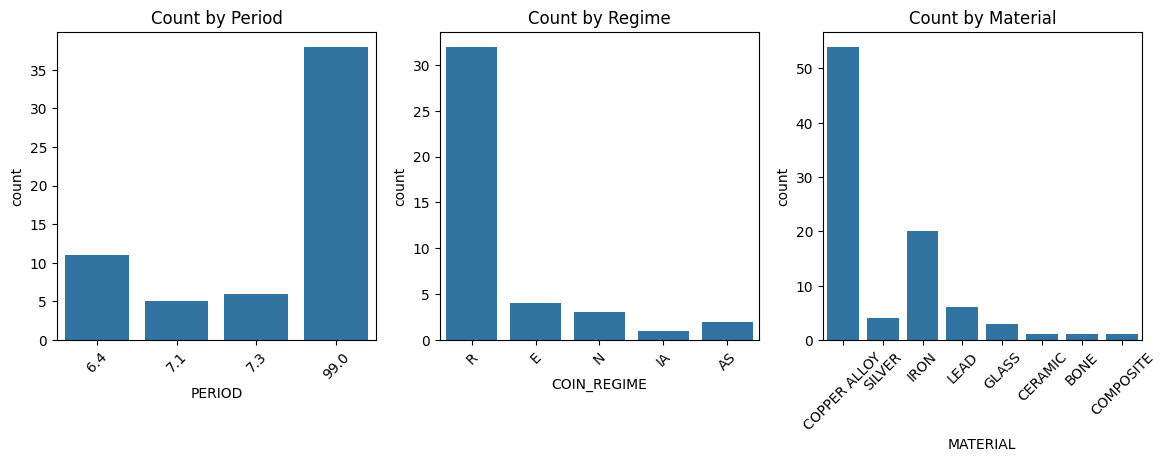

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(data=coins, x="PERIOD", ax=axes[0])
axes[0].set_title("Count by Period")
axes[0].tick_params(axis="x", rotation=45)

sns.countplot(data=coins, x="COIN_REGIME", ax=axes[1])
axes[1].set_title("Count by Regime")
axes[1].tick_params(axis="x", rotation=45)

sns.countplot(data=coins, x="MATERIAL", ax=axes[2])
axes[2].set_title("Count by Material")
axes[2].tick_params(axis="x", rotation=45)

- Period mostly 99.0 meaning "unphased" -> not many defined 
- Regime mostly R = Roman, other ones under 5 -> imbalanced 
- Material mistly Copper Alloy and Silver 

In [45]:
roman = coins[coins["COIN_REGIME"] == "R"]
roman["MATERIAL"].value_counts(dropna=False)

MATERIAL
COPPER ALLOY    32
Name: count, dtype: int64

- supports the argument that we cannot say alot about the material because the roman coins are all copper alloy (32)
- next question would be

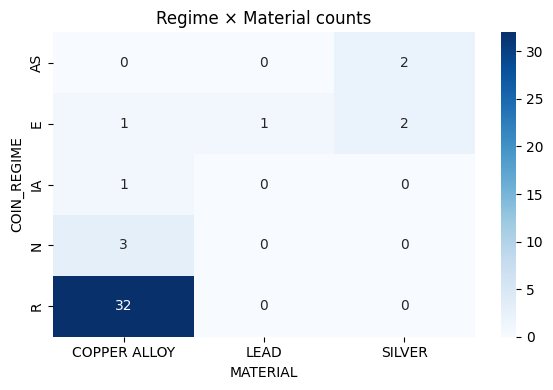

In [46]:
ct = pd.crosstab(coins["COIN_REGIME"], coins["MATERIAL"])
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Regime × Material counts")
plt.tight_layout()
plt.show()


In [47]:
copper = coins[coins["MATERIAL"] == "COPPER ALLOY"]
copper["COIN_REGIME"].value_counts(dropna=False) #include NaN values in the count



COIN_REGIME
R      32
NaN    17
N       3
IA      1
E       1
Name: count, dtype: int64

### INSIGHTS 
- Regime: The labeled coins are dominated by Roman (R). The other regimes (E, N, AS, IA) are only a handful each, so regime labels are highly imbalanced and many coins are missing regime.
- Material: The assemblage is mostly copper alloy, followed by iron. Other materials (lead, silver, glass, ceramic, bone, composite) are rare.
- Period: Most contexts are 99 (unphased/unknown), with far fewer in 6.4, 7.3, 7.1. So context phasing is sparse and dominated by unknowns.

### 2. Dates

- Calculating the average of the COIN_EDATE and COIN_LDATE (start and end date of an issue or range of a coin) to later cluster by century or decade and to compare issue over time
- mid_date gives a 'best guess' point as one value which could be useful for plotting
- date_span shows me if the coin is tightly or broadly dated

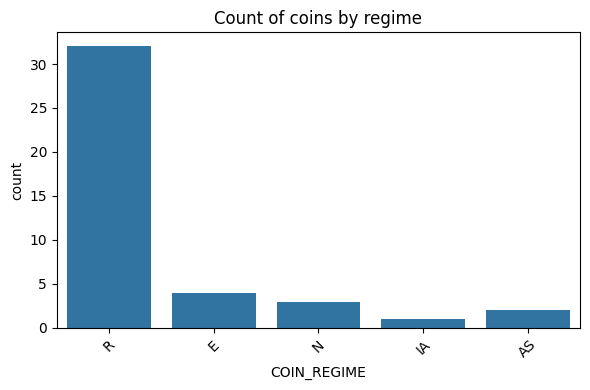

In [48]:
plt.figure(figsize=(6, 4))
sns.countplot(data=coins, x="COIN_REGIME")
plt.xticks(rotation=45)
plt.title("Count of coins by regime")
plt.tight_layout()
plt.show()

##### Interpretation of Coint Count Regime Plot
- The **count plot** shows quite an imbalanced assemblage: Roman (`R`) coins dominate the labelled sample (over 30 coins) while medieval (`E`), post-medieval (`N`), Iron Age (`IA`) and Anglo-Saxon (`AS`) regimes are represented by only a handful of coins each  <br>

- The boxplot also reveals that some regimes have **very few data points** (n is so small that the “box” may collapse to a line). -> Limited sample size for non-Roman regimes.

&rarr; A classifier for `COIN_REGIME` would probably learn 'Roman vs. everything else' and performance on minority regimes will be unstable. ML outcomes would have to be treated as exploratory.<br>


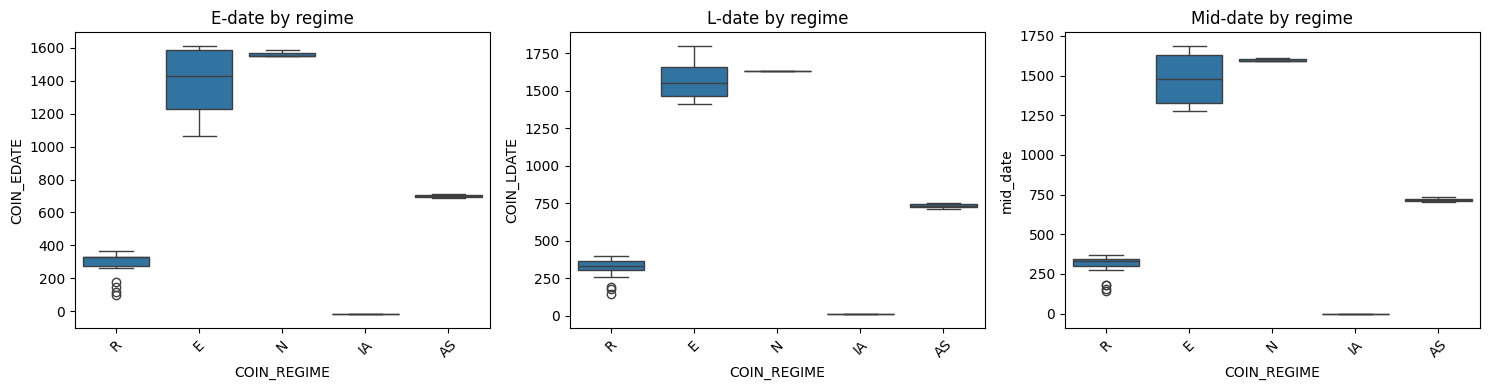

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(data=coins, x="COIN_REGIME", y="COIN_EDATE", ax=axes[0])
axes[0].set_title("E-date by regime")
axes[0].tick_params(axis="x", rotation=45)

sns.boxplot(data=coins, x="COIN_REGIME", y="COIN_LDATE", ax=axes[1])
axes[1].set_title("L-date by regime")
axes[1].tick_params(axis="x", rotation=45)

sns.boxplot(data=coins, x="COIN_REGIME", y="mid_date", ax=axes[2])
axes[2].set_title("Mid-date by regime")
axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()



##### Interpretation of the regime plots
- The **mid-date boxplot** shows clear chronological separation between regimes. Roman coins have mid-dates clustered in the first few centuries AD, medieval and post-medieval coins cluster much later (around 1300–1650), and Anglo-Saxon coins sit in between (around the 7th–8th centuries).<br>
&rarr; Indicates that `mid_date` encodes historically sensible information and will be a strong feature in both clustering and classification.


In [50]:
coins.groupby("COIN_REGIME")["mid_date"].describe()

,count,mean,std,min,25%,50%,75%,max
COIN_REGIME,,,,,,,,
AS,2.0,717.500000,21.213203,702.5,710.000,717.50,725.000,732.5
E,4.0,1480.625000,200.543584,1275.5,1328.375,1479.75,1632.000,1687.5
IA,1.0,-5.000000,NaN,-5.0,-5.000,-5.00,-5.000,-5.0
N,3.0,1598.500000,10.392305,1592.5,1592.500,1592.50,1601.500,1610.5
R,32.0,310.921875,62.044483,145.5,301.750,332.50,347.125,371.0


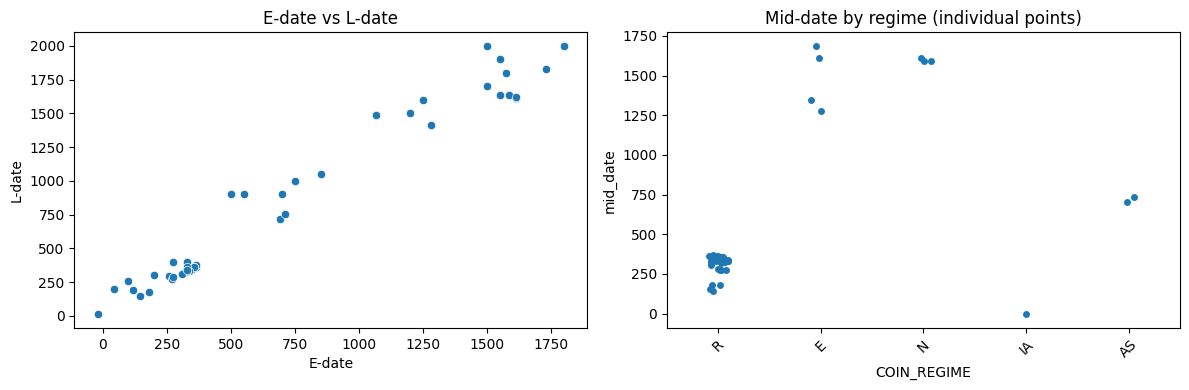

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=coins, x="COIN_EDATE", y="COIN_LDATE", ax=axes[0])
axes[0].set_title("E-date vs L-date")
axes[0].set_xlabel("E-date")
axes[0].set_ylabel("L-date")

sns.stripplot(data=coins, x="COIN_REGIME", y="mid_date", jitter=True, ax=axes[1])
axes[1].set_title("Mid-date by regime (individual points)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


#### Interpretation: 
- Date range per coin (precision): points form almost a diagonal so the dating windows are relatively narrow
- the points stretch from roughly 100 to 1800 so quite a wide timespan 
- most of them between 50 and 400 

- stripplot by regime to see the individual dates because of small N

<span style="color:red">!ATTENTION: For the boolean mask excluding 0 and negative values the data is distrubted so I will check with Count negatives in E and L dates </span>


In [52]:
neg_edate = (coins_raw["COIN_EDATE"] < 0).sum()
neg_ldate = (coins_raw["COIN_LDATE"] < 0).sum()

print("Negative E_DATE:", neg_edate)
print("Negative L_DATE:", neg_ldate)

Negative E_DATE: 1
Negative L_DATE: 0


<span style="color:green">!Validation: There is only one negative entry of -20 so it is not influencing the data too much </span>


### date span

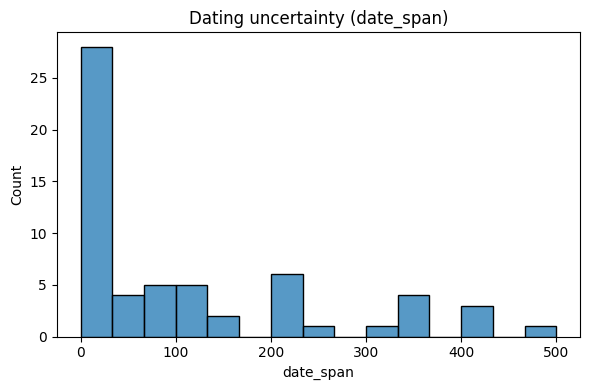

In [53]:
plt.figure(figsize=(6,4))
sns.histplot(data=coins, x="date_span", bins=15)
plt.title("Dating uncertainty (date_span)")
plt.tight_layout()
plt.show()


## 3. Size

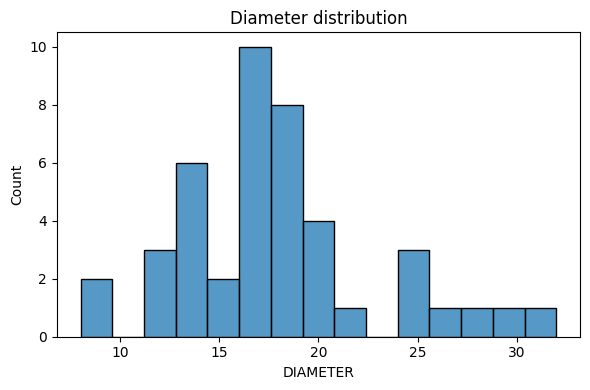

In [54]:
plt.figure(figsize=(6, 4))
sns.histplot(data=coins, x="DIAMETER", bins=15)
plt.title("Diameter distribution")
plt.tight_layout()
plt.show()

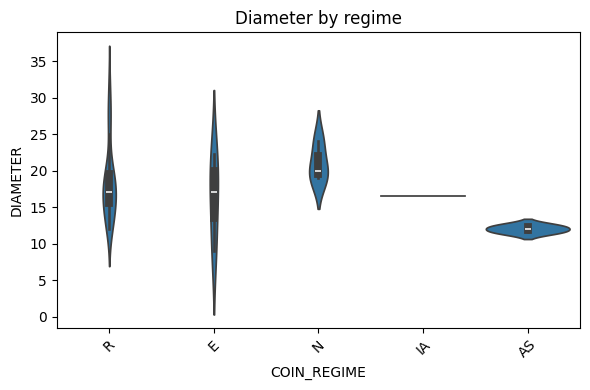

In [55]:
plt.figure(figsize=(6,4))
sns.violinplot(data=coins, x="COIN_REGIME", y="DIAMETER")
plt.xticks(rotation=45)
plt.title("Diameter by regime")
plt.tight_layout()
plt.show()


### 1.5 How many coins can be used for ML?

Not all rows have regime labels or numeric features.
Before modeling, I check effective sample sizes for possible clustering and classification:

Supervised classification (e.g., predict regime): requires labels + features.
Clustering: requires numeric features only.
This tells me whether ML is feasible or only illustrative given missingness.

In [56]:
# rows with a regime label
has_regime = coins["COIN_REGIME"].notna()
print("Coins with COIN_REGIME:", has_regime.sum())

# rows usable for clustering (need diameter + mid_date)
has_cluster_feats = coins["DIAMETER"].notna() & coins["mid_date"].notna()
print("Coins with diameter and mid_date:", has_cluster_feats.sum())

# rows usable for classification (regime + diameter + mid_date)
has_cls = has_regime & has_cluster_feats
print("Coins usable for regime classification:", has_cls.sum())


Coins with COIN_REGIME: 42
Coins with diameter and mid_date: 43
Coins usable for regime classification: 41


In [57]:
coins.to_csv("../data/conington_coins_clean.csv", index=False)


## Conclusion 

### Difficulties in cleaning 
- small dataset 
- sparse information
- dates like 99 (code or actual date)
- not being sure of certain numbers (regime 7.1, 99 and so on)
- different possibilities for dating methods

# Conclusion
### Key EDA outcomes
&check; NaNs & invalid dates: cleaned numeric fields and handled invalid zeros; kept negative years as BC/BCE. <br>
&check; Class balance: counts show strong imbalance and many missing labels (especially regime). <br>
&check; Dating precision: E/L/mid/date_span show many coins tightly dated but overall wide time coverage. <br>

### Difficulties in cleaning
- Small dataset size. <br>
- Sparse information across many fields. <br>
- Uncertainty about the meaning of numeric codes (e.g., 7.1, 99). <br>
- Different possible dating systems (context period vs coin‑based dates). <br>

### ML feasibility: 
- limited labeled rows for classification
- clustering possible but small and exploratory.

### Next step
Proceed to the clustering notebook, with clear caveats about small sample size and label sparsity.

In [73]:
coins.to_csv("/Users/bernadettekretzschmar/Desktop/LMU/MachineLearning/ML_DHC_Conington_Coindata/data/Coins_clean.csv", index=False) #save cleaned data to a new csv file